In [35]:
# Definitions and functions
%matplotlib inline
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os
import wave
import struct
import h5py
from scipy.io import wavfile
from scipy.signal import spectrogram
from basic_viewing import h5_functions as h5
import logging
from IPython.display import display
matplotlib.style.use('ggplot')
from ipywidgets import *
import yaml
import numpy.lib.recfunctions as rfn 
import numpy.matlib as npm
import glob
from __future__ import division
# Check wich computer to decide where the things are mounted
comp_name=socket.gethostname()
print 'Computer: ' + comp_name

if 'txori' in comp_name or 'passaro' in comp_name or 'lintu' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

sys.path.append(os.path.join(repos_folder, 'soundflow', 'sound_tools'))
sys.path.append(os.path.join(repos_folder, 'ephysflow'))
sys.path.append(os.path.join(repos_folder, 'analysis-tools'))

#setup the data folder
ss_data_folder = os.path.join(experiment_folder, 'ss_data')

import soundtools as st
import Kwik as oe
from file_tools import experiment as et
from basic_viewing import events as evt
from basic_viewing.units import Unit
from basic_viewing.basic_plot import plot_raster, sparse_raster
from basic_viewing import basic_plot as bp
from basic_viewing import kwik_functions as kwf


Computer: passaro


In [36]:
# bird and session

bird = 'z007'
sess = 'day-2016-09-10'
syn_sess = 2
# bird = 'z020'
# sess = 'day-2016-06-03'

exp_par = et.get_parameters(bird, sess)
fn = et.file_names(bird, sess)
song_file_path = et.file_path(fn, 'ss', 'sng')
song_file = h5py.File(song_file_path, 'r')

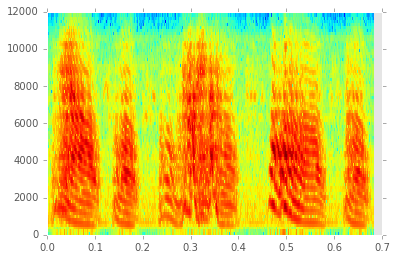

In [37]:
#pattern
m_name = 'motiff_1'
m_path = os.path.join(et.file_names(bird)['folders']['stim'], 
                      exp_par['search_motiff']['motiff_patterns'][m_name])

m = evt.Song(m_name, song_file)
m_chunk = st.Chunk(st.WavData2(m_path))
m_length = m_chunk.samples
#plt.plot(m_chunk.data)

n_window = 192
n_overlap = 191
sigma = 0.001 * 30000
f_cut = 12000
s_f = m_chunk.sound.s_f

pattern_spectrogram = spectrogram(m_chunk.data[:,0], s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma), 
                                  scaling='spectrum')

plt.pcolormesh(pattern_spectrogram[1], 
               pattern_spectrogram[0][pattern_spectrogram[0] < f_cut], 
               np.log(pattern_spectrogram[2][pattern_spectrogram[0] < f_cut, :]))

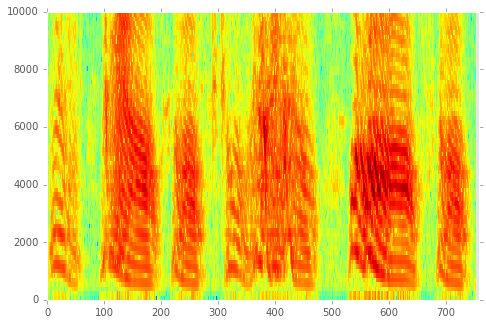

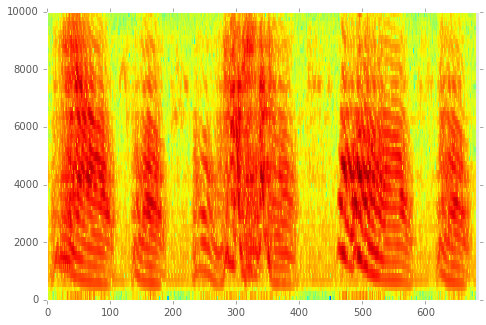

In [38]:
from __future__ import division
from scipy.signal import resample

def normalize(x):
    x_normed = (x - x.min(0)) / x.ptp(0)
    return x_normed

def stream_resample(stream, s_f, new_s_f):
    n_samples = stream.shape[0]
    new_samples = int(n_samples * new_s_f/s_f)
    return resample(stream, new_samples)

def load_syn_stream(bird, syn_sess=1, s_f=44100, new_s_f=30000, file_base='synth_bos'):
    stim_folder = et.file_names(bird)['folders']['stim']
    syn_file = os.path.join(stim_folder, str(syn_sess).zfill(3), file_base + '.dat')
    return stream_resample(np.loadtxt(syn_file), s_f, new_s_f)

def load_alpha_beta(bird, syn_sess=1, s_f=44100, new_s_f=30000, first=None):
    syn_par = load_syn_stream(bird, syn_sess=syn_sess, s_f=s_f, new_s_f=new_s_f)
    bos = load_syn_stream(bird, syn_sess=syn_sess, s_f=s_f, new_s_f=new_s_f, file_base='bos')
    env_bos = load_syn_stream(bird, syn_sess=syn_sess, s_f=s_f, new_s_f=new_s_f, file_base='env_bos')
    
    first = syn_par.shape[0] if first is None else first
    
    alpha = syn_par[:first,2]
    alpha[alpha>0] = 0
    alpha[alpha<0] = 0.3
    
    
    # equivalent to -alpha + 0.15 but getting rid of high frequency
    #env = st.envelope(bos[:alpha.shape[0]], window=300, conv_mode='same')
    
    env = env_bos[:first, 2]
    beta = -(syn_par[:first,1])
    beta[beta<0] = 0
 
    return (alpha), (beta), env

def plot_spectrogram(x, before_ms, after_ms, s_f, n_window = 192, n_overlap = None, sigma=None, ax=None, **kwargs):
    
    if n_overlap is None:
        n_overlap = n_window/2
    if sigma is None:
        sigma = 1./1000.*s_f
    
    # Make the spectrogram
    f, t, Sxx = spectrogram(x, s_f, nperseg = n_window, noverlap=n_overlap, window = sg.gaussian(n_window, sigma), 
                            scaling='spectrum')
    
    span_before = np.zeros((Sxx.shape[0], np.int(before_ms/1000. * s_f)))
    span_after = np.zeros((Sxx.shape[0], np.int(after_ms/1000. * s_f) + x.size - Sxx.shape[1]))
    span_before[:] = np.nan
    span_after[:] = np.nan
    #Sxx = np.hstack((span_before, (Sxx), span_after))
    
    if ax is None:
        spec_fig = plt.figure()
        ax = spec_fig.add_axes([0, 0, 1, 1])
        
    ax.pcolormesh(((t-0.5*n_window/s_f)*1000.), f, np.log(Sxx))
    ax.set_xlim(-before_ms, after_ms + int(x.size/s_f * 1000.))
    ax.set_ylim(0,10000)
    #ax.plot((span_before.shape[1], span_before.shape[1]), (np.min(f), np.max(f)), 'k--')
    
    return Sxx, ax

n_samples = m_chunk.samples - 512
bos = load_syn_stream(bird, file_base='bos')[:,]

spectr_bos, ax = plot_spectrogram(bos[:], 
                                   0, 0, 30000,
                                   n_window = 192, n_overlap=192-1, scaling='spectrum')

spectr_pattern, ax = plot_spectrogram(m_chunk.data[:].flatten(), 
                                   0, 0, 30000,
                                   n_window = 192, n_overlap=192-1, scaling='spectrum')

(97, 19850)

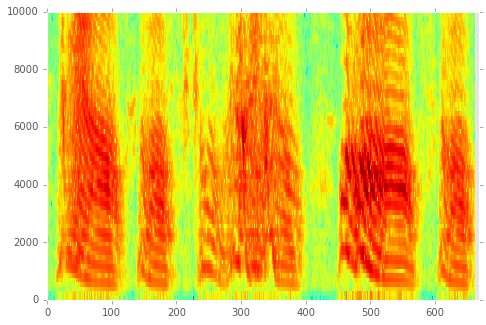

In [39]:
spectr_check, ax = plot_spectrogram(bos[2174+192:2174+192+n_samples],
                                   0, 0, 30000,
                                   n_window = 192, n_overlap=192-1, scaling='spectrum')
spectr_check.shape

ValueError: too many values to unpack

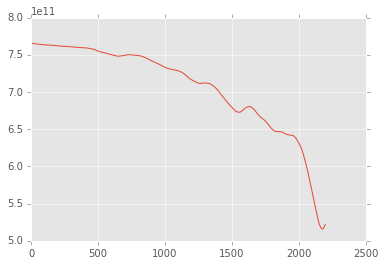

In [6]:
#compute the offset and load the signals
def running_diff(x, y):
    # y is the larger
    n_x = x.shape[1]
    n_y = y.shape[1]
    
    return np.array([np.sum(abs(x - y[:, i: i+n_x])) for i in range(n_y-n_x)])
    
rundif = running_diff(spectr_pattern, spectr_bos)
plt.plot(rundif)
offset = np.argmin(rundif)
syn_par = load_syn_stream(bird, syn_sess=syn_sess)[offset: offset + n_samples,:]
bos = load_syn_stream(bird, syn_sess=syn_sess, file_base='bos')[offset: offset + n_samples,]
synth_bos = load_syn_stream(bird, syn_sess=syn_sess, file_base='song_synth_bos')[offset: offset + n_samples,]
env = load_syn_stream(bird, syn_sess=syn_sess, file_base='env_bos')[offset: offset + n_samples,]
alpha, beta= [x[-n_samples:] for x in load_alpha_beta(bird, syn_sess=syn_sess)]
len_samples = n_samples

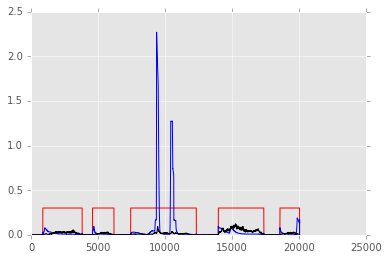

In [7]:
def load_alpha_beta(bird, syn_sess=1, s_f=44100, new_s_f=30000, first=None):
    syn_par = load_syn_stream(bird, syn_sess=syn_sess, s_f=s_f, new_s_f=new_s_f)
    bos = load_syn_stream(bird, syn_sess=syn_sess, s_f=s_f, new_s_f=new_s_f, file_base='bos')
    env_bos = load_syn_stream(bird, syn_sess=syn_sess, s_f=s_f, new_s_f=new_s_f, file_base='env_bos')
    
    first = syn_par.shape[0] if first is None else first
    
    alpha = syn_par[:first,2]
    alpha[alpha>0] = 0
    alpha[alpha<0] = 0.3
    
    
    # equivalent to -alpha + 0.15 but getting rid of high frequency
    #env = st.envelope(bos[:alpha.shape[0]], window=300, conv_mode='same')
    
    env = env_bos[:first, 2]
    beta = -(syn_par[:first,1])
    beta[beta<0] = 0
 
    return (alpha), (beta), env

syn_par = load_syn_stream(bird, syn_sess=syn_sess)[offset: offset + n_samples,:]
bos = load_syn_stream(bird, file_base='bos', syn_sess=syn_sess)[offset: offset + n_samples,]
synth_bos = load_syn_stream(bird, syn_sess=syn_sess, file_base='song_synth_bos')[offset: offset + n_samples,]
env = load_syn_stream(bird, syn_sess=syn_sess, file_base='env_bos')[offset: offset + n_samples,]
alpha, beta, envelope= [x[-n_samples:] for x in load_alpha_beta(bird, syn_sess=syn_sess)]
len_samples = n_samples

plt.plot(alpha,'r', beta, 'b', envelope/100, 'k')

In [9]:
def mulog(x, mu=256):
    return np.sign(x)*np.log(1. + mu*np.fabs(x))/np.log(1.+mu)

def mulog_vec(x, mu):
    return np.array([mulog(i) for i in x])

(97, 19850)

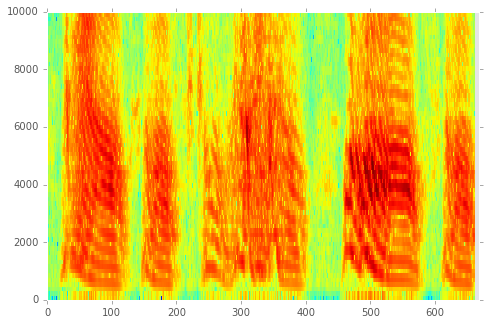

In [8]:
#check
spectr_check, ax = plot_spectrogram(bos[:],
                                   0, 0, 30000,
                                   n_window = 192, n_overlap=192-1, scaling='spectrum')
spectr_check.shape


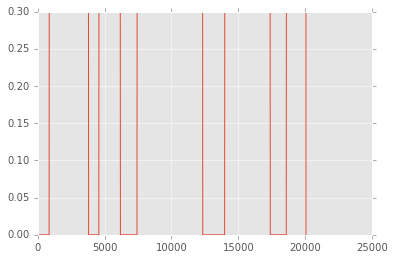

In [10]:
plt.plot(alpha)

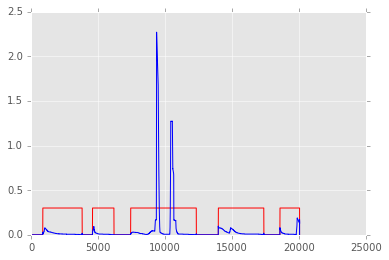

In [11]:
plt.plot(alpha,'r', beta, 'b')

In [13]:
def list_shank_units(bird, sess, shank, shank_file=None, sorted=False):
    meta_dt = np.dtype([('sess', 'S32', 1), ('shank', np.int, 1), ('is_good', 'b', 1)])
    kwik_file = et.open_kwik(bird, sess) if shank_file is None else et.open_kwik(bird, sess, shank_file)
    group = int(shank)
    all_units = kwf.list_units(kwik_file, group=group, sorted=False)
    n_units = all_units.size
    all_meta = np.recarray(n_units, dtype=meta_dt)
    all_meta['sess'] = sess
    all_meta['shank'] = shank
    all_meta['is_good'] = True
    return rfn.merge_arrays((all_meta, all_units), asrecarray=True, flatten=True)

get_shanks_list = et.get_shanks_list

def list_sess_units(bird, sess, sorted=False):
    shanks = get_shanks_list(bird, sess)
    sess_units = None
    for shank in shanks:
        kwik_file = et.open_kwik(bird, sess)
        shank_units = list_shank_units(bird, sess, shank, sorted=False)
        if sess_units is None:
            sess_units = shank_units
        else:
            sess_units = rfn.stack_arrays((sess_units, shank_units))
    return sess_units

all_sess_units = list_sess_units(bird, sess)

In [40]:
# Neural data
shank = 0

kwik_file = et.open_kwik(bird, sess)
m_starts = kwf.apply_rec_offset(kwik_file, m.get_start(), m.get_rec())
#m_starts = m.get_start()
all_units = kwf.list_units(kwik_file, group=shank, sorted=False)

# this returns a numpy recarray with cols:
# group: site group (electrode shank)
# clu: cluster number
# qlt: sorting quality: 1 is MUA, 2 is well isolated (by default, only these 2 qlt's are returned)
# For instance, see all the clusters that are either mua or good units.
print all_units['clu']


[ 0  1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30
 31 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45 46 47 48 49  5 50 51 52 53
 54 55 56 57 58 59  6 60 61 62 63  7  8  9]


selected unit 43


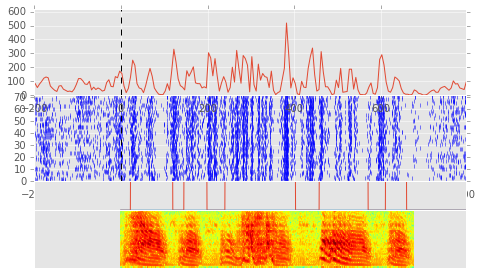

In [41]:
def plot_spectrogram(x, before_ms, after_ms, s_f, n_window = 192, n_overlap = None, sigma=None, ax=None, **kwargs):
    if n_overlap is None:
        n_overlap = n_window/2
    if sigma is None:
        sigma = 1./1000.*s_f
    
    # Make the spectrogram
    f, t, Sxx = spectrogram(x, s_f, nperseg = n_window, noverlap=n_overlap, window = sg.gaussian(n_window, sigma), scaling='spectrum')
    
    span_before = np.zeros((Sxx.shape[0], np.int(before_ms/1000. * s_f)))
    span_after = np.zeros((Sxx.shape[0], np.int(after_ms/1000. * s_f) - Sxx.shape[1]))
    span_before[:] = np.nan
    span_after[:] = np.nan
    #Sxx = np.hstack((span_before, (Sxx), span_after))
    
    if ax is None:
        spec_fig = plt.figure()
        ax = spec_fig.add_axes([0, 0, 1, 1])
        
    ax.pcolormesh(((t-0.5*n_window/s_f)*1000.), f, np.log(Sxx))
    ax.set_xlim(-before_ms, after_ms)
    ax.set_ylim(0,10000)
    #ax.plot((span_before.shape[1], span_before.shape[1]), (np.min(f), np.max(f)), 'k--')
    
    return Sxx, ax

def plot_waveform(x, before_ms, after_ms, s_f, ax=None):
    span_before = np.zeros(np.int(before_ms/1000. * s_f))
    span_before[:] = np.nan
    span_after = np.zeros(np.int(after_ms/1000. * s_f) - x.size)
    waveform_plot = np.insert(x, 0, span_before)
    waveform_plot = np.insert(span_after, 0, waveform_plot)
    waveform_t_plot = np.arange(waveform_plot.size)*1000./s_f
    if ax is None:
        raster_fig = plt.figure()
        ax = raster_fig.add_axes([0, 0, 1, 1])
    ax.plot(waveform_plot)
    ax.set_xlim(0, waveform_plot.size)
    ax.plot((span_before.size, span_before.size), (np.min(waveform_plot), np.max(waveform_plot)), 'k--')
    return ax

def plot_one_raster(unit_clu):
    # instance a Unit object
    unit = Unit(unit_clu, kwik_file=kwik_file)
    # get the spike times (in sample units)
    unit.get_time_stamps()
    # get the sampling rate of the recording
    s_f = unit.sampling_rate
    #get a raster for this unit around a window of [-2, 4] sec after each stimulus onset
    before_ms = 1000
    after_ms = 1600
    start_points = m_starts - np.int(s_f * before_ms/1000.) #start_points has to be in sample units
    rs = unit.get_raster(start_points, before_ms + after_ms, span_is_ms=True, return_ms=True)
    # the raster is an n_trial * m array (where m can be sample or ms).
    # in each row, it contains the timestamps (in samples or ms) of spikes relative to the beginning of the trial
    # plot the raster
    b = np.outer((np.arange(rs.shape[0]) + 1), np.ones(rs.shape[1]))
    plt.figure(unit_clu)
    plt.scatter(rs, b, marker='|')
    plt.xlim(0, before_ms + after_ms)
    plt.show
    
class VizUnit():
    def __init__(self, all_units, pattern_chunk, event):
        self.unit = None
        self.raster = None
        self.clu = all_units['clu']
        self.all_units = all_units
        self.is_good = Checkbox()
        self.fig = None
        self.fig_width = 1
        self.fig_ax = {}
        self.pattern_chunk = pattern_chunk
        self.pattern = pattern_chunk.data.reshape(pattern_chunk.data.size,)
        self.before_ms = 200
        self.after_ms = 800
        self.start_points = None
        self.s_f = pattern_chunk.sound.s_f
        self.spectr = None
        self.event = None
        #display(self.is_bout)
        
        self.init_event(event)
        self.init_fig()
        
    def show(self, i):
        i_clu = i
        self.select_unit(i_clu)
        print 'selected unit {}'.format(i_clu)
        ax1 = self.fig_ax['raster']
        ax2 = self.fig_ax['histogram']
        ax1.cla()
        ax2.cla()
        rast, ax1 = plot_raster(sparse_raster(self.raster), t0=self.before_ms, ax=ax1)
        rast, ax2 = plot_raster(sparse_raster(self.raster), t0=self.before_ms, bin_size=5, ax=ax2)
        display(self.fig)
    
    def select_unit(self, unit_clu):
        self.unit = Unit(unit_clu, kwik_file=kwik_file)
        self.raster = self.unit.get_raster(self.start_points, self.before_ms + self.after_ms, 
                                           span_is_ms=True, return_ms=True)
    
    def init_event(self, event):
        self.event = event
        m_starts = kwf.apply_rec_offset(kwik_file, self.event.get_start(), self.event.get_rec())
        self.start_points = m_starts - np.int(self.s_f * self.before_ms/1000.)
        
    def init_fig(self):
        self.fig = plt.figure()
        self.fig_ax['raster'] = self.fig.add_axes([0,.3,self.fig_width,0.3])
        self.fig_ax['histogram'] = self.fig.add_axes([0,.6,self.fig_width,0.3])
        self.fig_ax['spectrogram'] = self.fig.add_axes([0,0,self.fig_width,0.2])
        self.fig_ax['synthesis'] = self.fig.add_axes([0,.2,self.fig_width,0.1])
        for ax in self.fig_ax.itervalues():
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
        self.update_spectrogram()
        self.update_synth_plot()

    def update_spectrogram(self):
        ax = self.fig_ax['spectrogram']
        m_chunk = self.pattern_chunk
        self.spectr, ax = plot_spectrogram(m_chunk.data.reshape(m_chunk.data.size,), 
                                           self.before_ms, self.after_ms, m_chunk.sound.s_f, 
                                           ax=ax, 
                                           n_window = 192, n_overlap=192-1, scaling='spectrum')
    def update_synth_plot(self):
        ax = self.fig_ax['synthesis']
        ax = plot_waveform(alpha[192:,], self.before_ms, self.after_ms, m_chunk.sound.s_f, ax=ax)
        ax = plot_waveform(beta[192:,], self.before_ms, self.after_ms, m_chunk.sound.s_f, ax=ax)
        
        
        
    def bout_checked(self, bc):
#         print "bout checked"
#         print bc['new']
#         print self.motiff
        self.candidates.set_value(self.motiff, 'bout', bc['new'])
    # inspect the result

vu = VizUnit(all_units, m_chunk, m)
widgets.interact(vu.show, i=(0, all_units['clu'].size-1, 1))

In [ ]:
kilosort

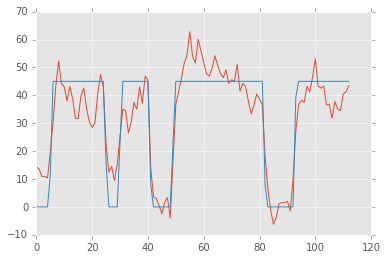

In [16]:
motiff_starts_kwik = kwf.apply_rec_offset(kwik_file, vu.event.get_start(), vu.event.get_rec())
# make an array of n_bins * n_units * n_starts

bin_size = 5
history_bins = 21

# n_ms = int(len_samples/s_f*1000.)
# bin_size_samples = int(bin_size*s_f/1000)

# n_bins = int(np.floor((n_ms)/bin_size)) + history_bins
# n_starts = motiff_starts_kwik.size
# n_units = all_units.size


# sup_vec = np.empty([n_units, n_starts, n_bins], dtype=int)
# model_pars = bp.col_binned(np.array([alpha, beta]), bin_size_samples)

# for i, unit_meta in enumerate(all_units):
#     clu = unit_meta['clu']
#     unit = Unit(clu, kwik_file=kwik_file)
#     rs = unit.get_raster(motiff_starts_kwik - int(history_bins*bin_size*s_f/1000), 
#                          n_ms + bin_size*(history_bins-1), 
#                          span_is_ms=True, 
#                          return_ms=True)
#     sup_vec[i, :, :] = bp.col_binned(sparse_raster(rs), bin_size)
    
# good_units = np.where([np.any(sup_vec[u, :, :]) for u in range(sup_vec.shape[0])])
# god_vec = sup_vec[good_units,:,:][0]

def gimme_good_vec(starts, len_samples, all_units, kwik_file, alpha, beta, s_f=30000, bin_size=10, history_bins=1):
    n_ms = int(len_samples/s_f*1000.)
    bin_size_samples = int(bin_size*s_f/1000.)
    
    n_bins = int(np.floor((n_ms)/bin_size)) + history_bins
    n_starts = starts.size
    n_units = all_units.size
    
    model_pars = bp.col_binned(np.array([alpha, beta, envelope]), bin_size_samples)
    sup_vec = np.empty([n_units, n_starts, n_bins], dtype=int)  
    for i, unit_meta in enumerate(all_units):
        clu = unit_meta['clu']
        unit = Unit(clu, kwik_file=kwik_file)
        rs = unit.get_raster(starts - int(history_bins*bin_size*s_f/1000), 
                             n_ms + bin_size*(history_bins-1), 
                             span_is_ms=True, 
                             return_ms=True)
        sup_vec[i, :, :] = bp.col_binned(sparse_raster(rs), bin_size)
    
    good_units = np.where([np.any(sup_vec[u, :, :]) for u in range(sup_vec.shape[0])])
    
    return sup_vec[good_units,:,:][0], model_pars

def unit_array(god_vec, i_u, i_tr, m, N):    
    x = np.vstack([god_vec[i_u, i_tr, i_0: i_0 + N-1] for i_0 in range(m)])
    return x

def all_units_array(god_vec, i_tr, m, N):
    x = np.hstack([unit_array(god_vec, u, i_tr, m, N) for u in range(god_vec.shape[0])])
    return np.hstack([np.ones([x.shape[0], 1]), x])

def fit_kernel(god_vec, target, trials, history_bins=10):
    # with this simple support vector make a linear decoder as in warland
    N = history_bins # history bins
    
    v = god_vec.shape[0] #number of units
    M = god_vec.shape[2] #len of recording
    m = M-N
    
    bigR = np.vstack([all_units_array(god_vec, i_tr, m, N) for i_tr in trials])
    s = np.tile(target[:m], trials.size)
    c = np.dot(bigR.T, bigR)
    rc = np.dot(bigR.T, s)
    f = np.dot(np.linalg.inv(c), rc)
    
    return f

def test_kernel(god_vec, target, kernel, trials, history_bins):
    N = history_bins
    M = god_vec.shape[2]
    m = M - N
    all_fits = np.vstack([np.dot(all_units_array(god_vec, tr_test, m, N), kernel) for tr_test in trials])
    all_fits[all_fits<0]=0
    
    all_residual = np.einsum('ij,ij', all_fits - target[:m], all_fits - target[:m])
    err = all_residual/np.einsum('i,i', target[:m], target[:m])  
    return err, all_fits


god_vec, model_pars = gimme_good_vec(motiff_starts_kwik, len_samples, all_units, kwik_file, alpha, beta, 
                                     s_f=30000, 
                                     bin_size=bin_size, 
                                     history_bins=1)

# with this simple support vector make a linear decoder as in warland
N = history_bins# history bins
M = god_vec.shape[2] #len of recording
m = M-N

n_trials = 65
f_fit_alpha = fit_kernel(god_vec, model_pars[0,:], np.arange(n_trials), history_bins=N)
f_fit_beta = fit_kernel(god_vec, model_pars[1,:], np.arange(n_trials), history_bins=N)
f_fit_env = fit_kernel(god_vec, model_pars[2,:], np.arange(n_trials), history_bins=N)
f_fit_betalog = fit_kernel(god_vec, mulog_vec(model_pars[1,:m]/350, 512), np.arange(n_trials), history_bins=N)

tr_test = 69
u_alpha = np.dot(all_units_array(god_vec, tr_test, m, N), f_fit_alpha)
u_beta = np.dot(all_units_array(god_vec, tr_test, m, N), f_fit_beta)
u_betalog = np.dot(all_units_array(god_vec, tr_test, m, N), f_fit_betalog)
u_env = np.dot(all_units_array(god_vec, tr_test, m, N), f_fit_env)

plt.plot(u_alpha)
plt.plot(model_pars[0,:m])

d, alfits = test_kernel(god_vec, model_pars[1,:], f_fit_beta, np.arange(67,69), N)


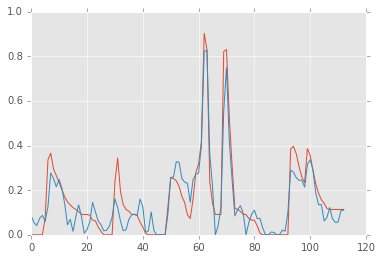

In [17]:
plt.plot(mulog_vec(model_pars[1,:m]/350, 512))
u_betalog[u_betalog<0]=0
plt.plot(u_betalog)

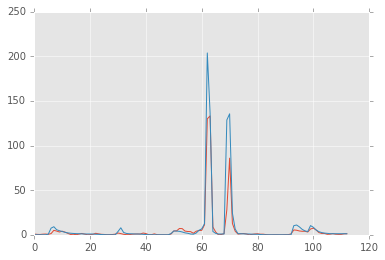

In [18]:
def inverse_mulog_vec(y, mu=256):
    return np.sign(y)/mu * (np.power((1. + mu)*np.ones_like(y), np.fabs(y)) - 1.)

beta = inverse_mulog_vec(u_betalog)*350
plt.plot(beta)
plt.plot(model_pars[1,:m])

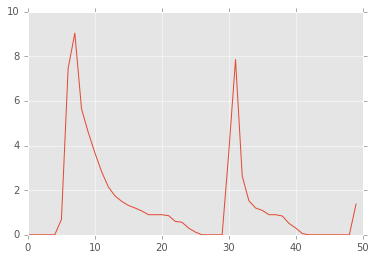

In [26]:
plt.plot(model_pars[1,:50])

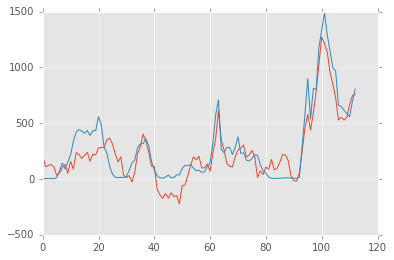

In [19]:
plt.plot(u_env)
plt.plot(model_pars[2,:m])

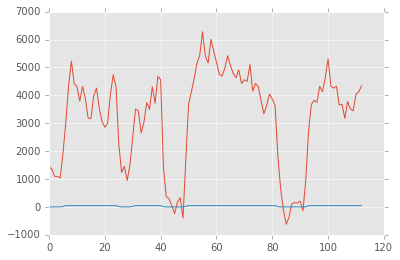

In [20]:
#u_alpha[u_alpha<45]=0.
#u_alpha[u_alpha>45]=-.15
plt.plot(u_alpha*100)
plt.plot(model_pars[0,:m])

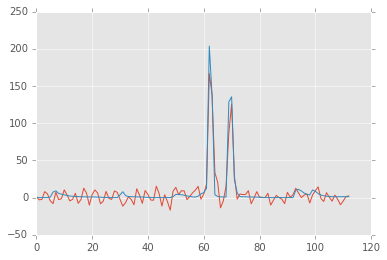

In [27]:
plt.plot(u_beta)
plt.plot(model_pars[1,:m])

In [21]:
def resample_interp(x, s_f, new_s_f):
    t = np.linspace(0, x.size/s_f, x.size)
    #print t
    new_t = np.linspace(0, x.size/s_f, np.int(x.size*new_s_f/s_f))
    print new_t.shape
    return np.interp(new_t, t, x)


(24916,)
(24916,)
(24916,)
(24916,)
(24916,)
(24916,)


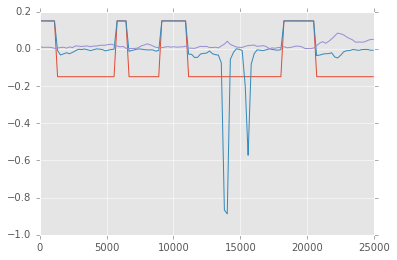

In [33]:
# export the parameters
scale_factor = 150

a = 0.15*np.ones_like(u_alpha)
a[u_alpha>22] = -0.15

b = -beta/scale_factor
b[b>0]=0.15
b[a>0]=0.15

e = np.abs(u_env) /scale_factor

exports = [resample_interp(x, 1000./bin_size, 44100) for x in [b, a, e]]

plt.plot(resample_interp(a, 1000./bin_size, 44100))
plt.plot(resample_interp(b, 1000./bin_size, 44100))
plt.plot(resample_interp(e/100, 1000./bin_size, 44100))


synth_bos_array = np.zeros([exports[0].size, 5])
synth_bos_array[:,0] = np.linspace(0, exports[0].size/44100, exports[0].size)
synth_bos_array[:,1] = exports[0]
synth_bos_array[:,2] = exports[1]

env_bos_array = np.zeros([exports[0].size, 3])
env_bos_array[:,0] = np.linspace(0, exports[0].size/44100, exports[0].size)
env_bos_array[:,2] = exports[2]


def write_array(bird, x, file_base, syn_sess=1, fmt='%lg'):
    stim_folder = et.file_names(bird)['folders']['stim']
    syn_file = os.path.join(stim_folder, str(syn_sess).zfill(3), file_base + '.dat')
    np.savetxt(syn_file, x, fmt=fmt)
    
write_array('z007', env_bos_array, 'env_fit', syn_sess=syn_sess)
write_array('z007', synth_bos_array, 'synth_fit', syn_sess=syn_sess)


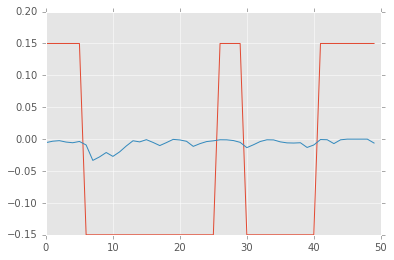

In [32]:
plt.plot(a[:50])
plt.plot(b[:50])

In [408]:
#parameter sweep
bs = np.arange(5,30,5)
hs = np.arange(1,35,5)

total_trials = sup_vec.shape[1]
test_trials_n = 10

all_trials = np.arange(total_trials)
np.random.shuffle(all_trials)
train_trials = all_trials[:-test_trials_n]
test_trials = all_trials[-test_trials_n:]

n_b = bs.size
n_s = hs.size

d_array = np.zeros([n_b, n_s, 2])

for i_bin, bin_size in enumerate(bs):
    print 'Bin Size {}'.format(bin_size)
    bin_R, bin_pars = gimme_good_vec(motiff_starts_kwik, len_samples, all_units, kwik_file, alpha, beta, 
                          s_f=s_f, bin_size=bin_size, history_bins=1)
    
    for i_hist, history_size in enumerate(hs):
        m_test = bin_R.shape[2] - history_size
        for i_par in [0, 1]:
            bin_f = fit_kernel(bin_R, bin_pars[i_par,:], test_trials, history_bins=history_size)
            dist, u = test_kernel(bin_R, bin_pars[i_par, :m_test], bin_f, test_trials, history_size)
            print 'Hist Size {0}, par {1} dist {2}'.format(history_size, i_par, dist)
            d_array[i_bin, i_hist, i_par] = dist

Bin Size 5
Hist Size 1, par 0 dist 5.8545770784
Hist Size 1, par 1 dist 5.70606762602
Hist Size 6, par 0 dist 3.06233682114
Hist Size 6, par 1 dist 2.56482032689
Hist Size 11, par 0 dist 1.56936171082
Hist Size 11, par 1 dist 1.14364672639
Hist Size 16, par 0 dist 0.608550263682
Hist Size 16, par 1 dist 0.5076121103
Hist Size 21, par 0 dist 0.0174177249053
Hist Size 21, par 1 dist 0.0214087504948
Hist Size 26, par 0 dist 6794809.34867
Hist Size 26, par 1 dist 7157375.26137
Hist Size 31, par 0 dist 37051310.0704
Hist Size 31, par 1 dist 45781199.4438
Bin Size 10
Hist Size 1, par 0 dist 5.77350934655
Hist Size 1, par 1 dist 5.55951665374
Hist Size 6, par 0 dist 1.38608015588
Hist Size 6, par 1 dist 1.09170516974
Hist Size 11, par 0 dist 3278.0705197
Hist Size 11, par 1 dist 3723.0913661
Hist Size 16, par 0 dist 2866823.89875
Hist Size 16, par 1 dist 3705281.24476
Hist Size 21, par 0 dist 2302307.30672
Hist Size 21, par 1 dist 1249745.47845
Hist Size 26, par 0 dist 2661388.85751
Hist Size

LinAlgError: Singular matrix

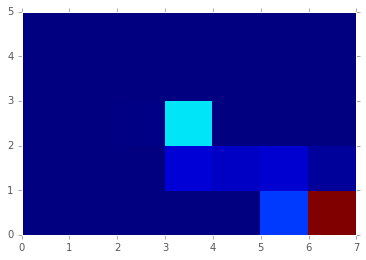

In [410]:
plt.pcolormesh(d_array[:,:,0])

In [412]:
d_array[0,:,0]

array([  5.85457708e+00,   3.06233682e+00,   1.56936171e+00,
         6.08550264e-01,   1.74177249e-02,   6.79480935e+06,
         3.70513101e+07])

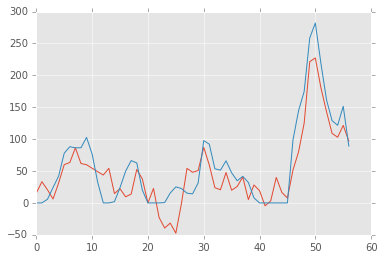

In [212]:
plt.plot(u)
plt.plot(model_pars[0,:m])